In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

### Обработка

In [48]:
def process_files_with_standardization(input_folder, output_folder):
    file_paths = glob.glob(os.path.join(input_folder, "*.csv"))
    os.makedirs(output_folder, exist_ok=True)
    
    output_files = []
    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
    
        model = ARIMA(df['TRADEPRICE'], order=(1, 0, 0))
        fit = model.fit()
        
#         df['RESIDUALS'] = fit.resid
        df['RESIDUALS'] = df['TRADEPRICE'] - fit.predict(start=0, end=df['TRADEPRICE'].shape[0])
    
        # Z-score - удаляем значения, отклоняющия от среднего более чем на 3 стандартных отклонения
        df['Z_SCORE'] = np.abs((df['RESIDUALS'] - df['RESIDUALS'].mean()) / df['RESIDUALS'].std())

        df_filtered = df[df['Z_SCORE'] < 3].copy()

        if df_filtered.shape[0] > 10000:
            df_filtered = df_filtered.reset_index(drop=True)
        
        mean = df_filtered['RESIDUALS'].mean()
        std = df_filtered['RESIDUALS'].std()
        df_filtered['STANDARDIZED_NOISE'] = (df_filtered['RESIDUALS'] - mean) / std
        
        # межквартильный размах
        Q1 = df_filtered['STANDARDIZED_NOISE'].quantile(0.25)
        Q3 = df_filtered['STANDARDIZED_NOISE'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_filtered = df_filtered[(df_filtered['STANDARDIZED_NOISE'] >= lower_bound) & (df_filtered['STANDARDIZED_NOISE'] <= upper_bound)]
        
        for _ in range(5):  # удаляем 5 самых больших выбросов
            max_idx = df_filtered['STANDARDIZED_NOISE'].idxmax()
            df_filtered = df_filtered.drop(index=max_idx)

        required_columns = ['index', 'TIME', 'STANDARDIZED_NOISE']
        missing_columns = [col for col in required_columns if col not in df_filtered.columns]
        if missing_columns:
            raise KeyError(f"The following columns are missing: {missing_columns}")
    
        file_name = os.path.basename(file_path)
        output_file_path = os.path.join(output_folder, f"noise_{file_name}")
        df_filtered[['index', 'TIME', 'STANDARDIZED_NOISE']].to_csv(output_file_path, index=False)
        output_files.append(output_file_path)
        
    return output_files

### Визуализация

In [49]:
def plot_standardized_noise(df, color='darkblue', label='STANDARDIZED_NOISE'):
    plt.figure()

    noise_mc = df['STANDARDIZED_NOISE']

    plt.plot(
        df.index, noise_mc / np.std(noise_mc), 
        color=color, linewidth=0.7, label=label
    )

    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title('STANDARDIZED_NOISE', fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.legend(fontsize=12, loc='upper right')

    plt.show()

In [50]:
def plot_standardized_noise_from_folder(input_folder):
    file_paths = glob.glob(os.path.join(input_folder, "*.csv"))

    plt.figure(figsize=(12, 6))

    colors = plt.cm.jet(np.linspace(0, 1, len(file_paths)))

    for file_path, color in zip(file_paths, colors):
        df = pd.read_csv(file_path)

        if 'index' in df.columns and 'STANDARDIZED_NOISE' in df.columns:
            plt.plot(
                df['index'], df['STANDARDIZED_NOISE'] / np.std(df['STANDARDIZED_NOISE']),
                color=color, linewidth=0.7, label=os.path.basename(file_path)
            )

    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title('STANDARDIZED_NOISE для всех файлов', fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=9, loc='upper right', ncol=2)

    plt.show()

In [51]:
def plot_standardized_noise_grid(input_folder, rows=3, cols=4):
    file_paths = glob.glob(os.path.join(input_folder, "*.csv"))

    if not file_paths:
        print("Нет файлов для обработки в указанной папке.")
        return

    num_plots = min(len(file_paths), rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, file_path in enumerate(file_paths[:num_plots]):
        df = pd.read_csv(file_path)

        if 'index' in df.columns and 'STANDARDIZED_NOISE' in df.columns:
            ax = axes[i]
            ax.plot(
                df['index'], df['STANDARDIZED_NOISE'] / np.std(df['STANDARDIZED_NOISE']), 
                color='darkblue', linewidth=0.7
            )
            ax.set_title(os.path.basename(file_path), fontsize=10)
            ax.set_xlabel('Время', fontsize=9)
            ax.set_ylabel('Значение', fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.5)

    # Удаляем лишние пустые графики, если файлов меньше, чем ячеек в сетке
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## SBER

In [52]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_s_11.csv']

In [53]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises/noise_b_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0            2   70000303662           -1.235505
1            3   70000353538           -1.252859
2            4   70000366320           -1.224408
3            5   70000370183           -1.234332
4            6   70000372471           -1.234332
...        ...           ...                 ...
344855  344922  183955575679            1.359373
344856  344923  183956010535            1.350492
344857  344924  183956429775            1.323976
344858  344925  183956995801            1.362361
344859  344926  183958716416            1.350633

[344860 rows x 3 columns]

In [54]:
# # соединение файлов зачем-то

# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# noises_dir = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises"

# noise_files = [os.path.join(noises_dir, f) for f in os.listdir(noises_dir) if f.endswith('.csv')]

# df_list = [pd.read_csv(file) for file in noise_files]
# df = pd.concat(df_list, ignore_index=True)

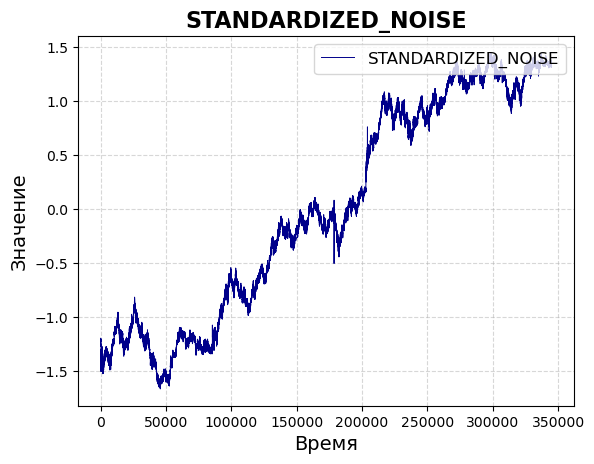

In [55]:
plot_standardized_noise(df)

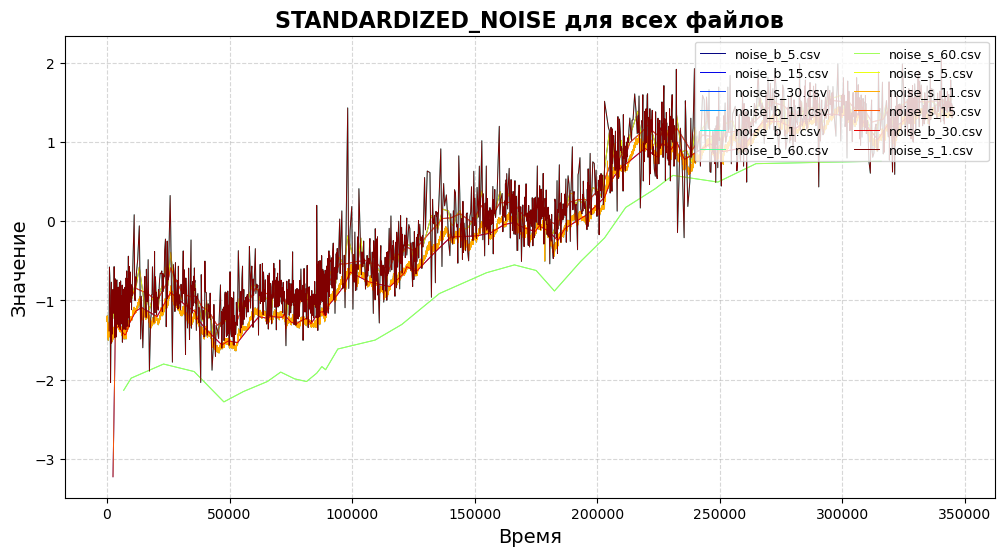

In [56]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises"
plot_standardized_noise_from_folder(input_folder)

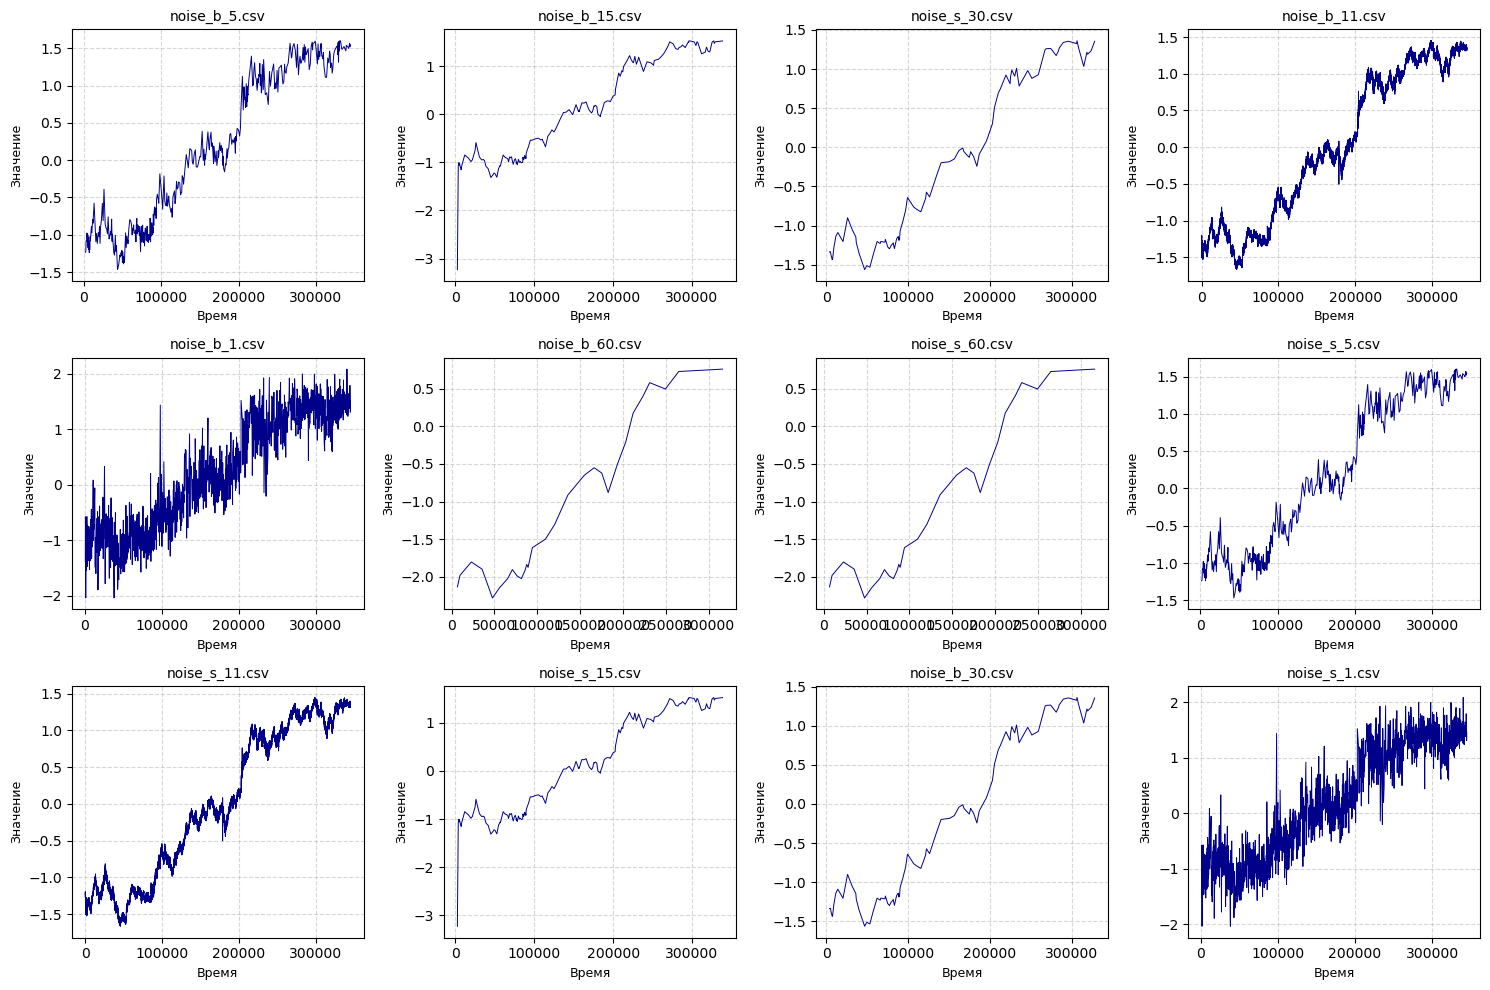

In [57]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBER/noises"
plot_standardized_noise_grid(input_folder)

## SBERP

In [58]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_11.csv']

In [59]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0          3   70001680864            1.298097
1          4   70001723393           -1.194349
2          6   70001787858           -1.920126
3          7   70001800071            2.476320
4          9   70001886150           -1.278675
...      ...           ...                 ...
69719  69750  183951292681            2.146168
69720  69751  183951368249            1.764666
69721  69752  183955073168            0.367407
69722  69753  183955171626            1.329404
69723  69754  183955500861            1.329404

[69724 rows x 3 columns]

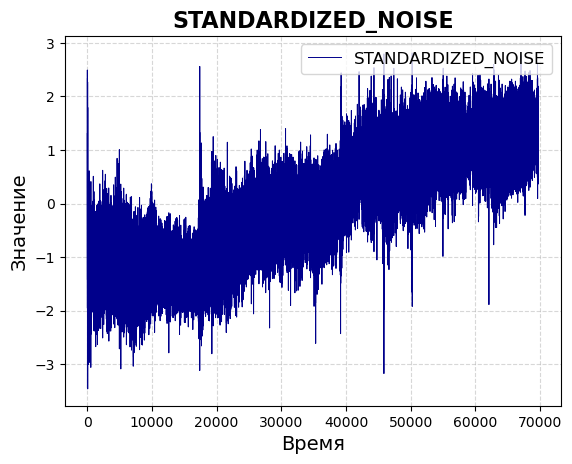

In [60]:
plot_standardized_noise(df)

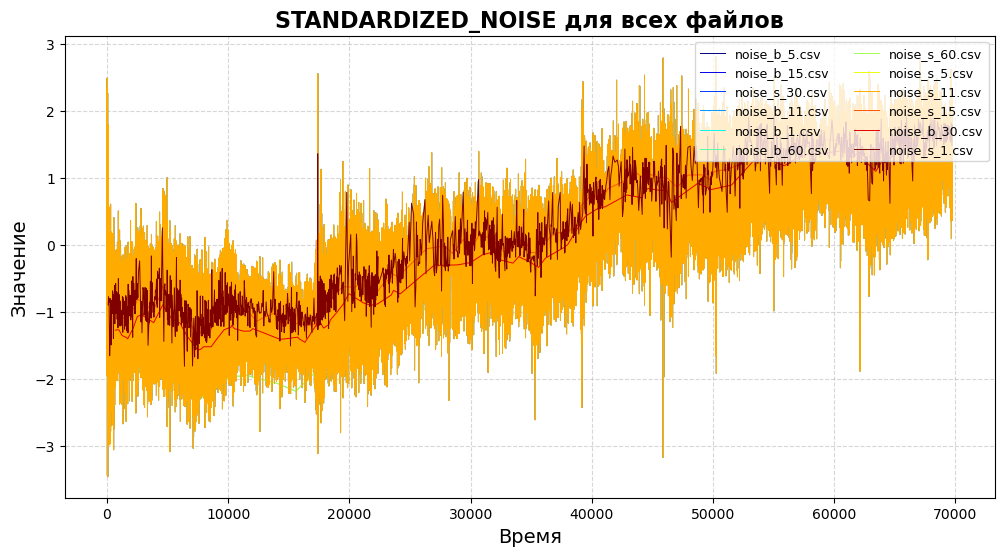

In [61]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises"
plot_standardized_noise_from_folder(input_folder)

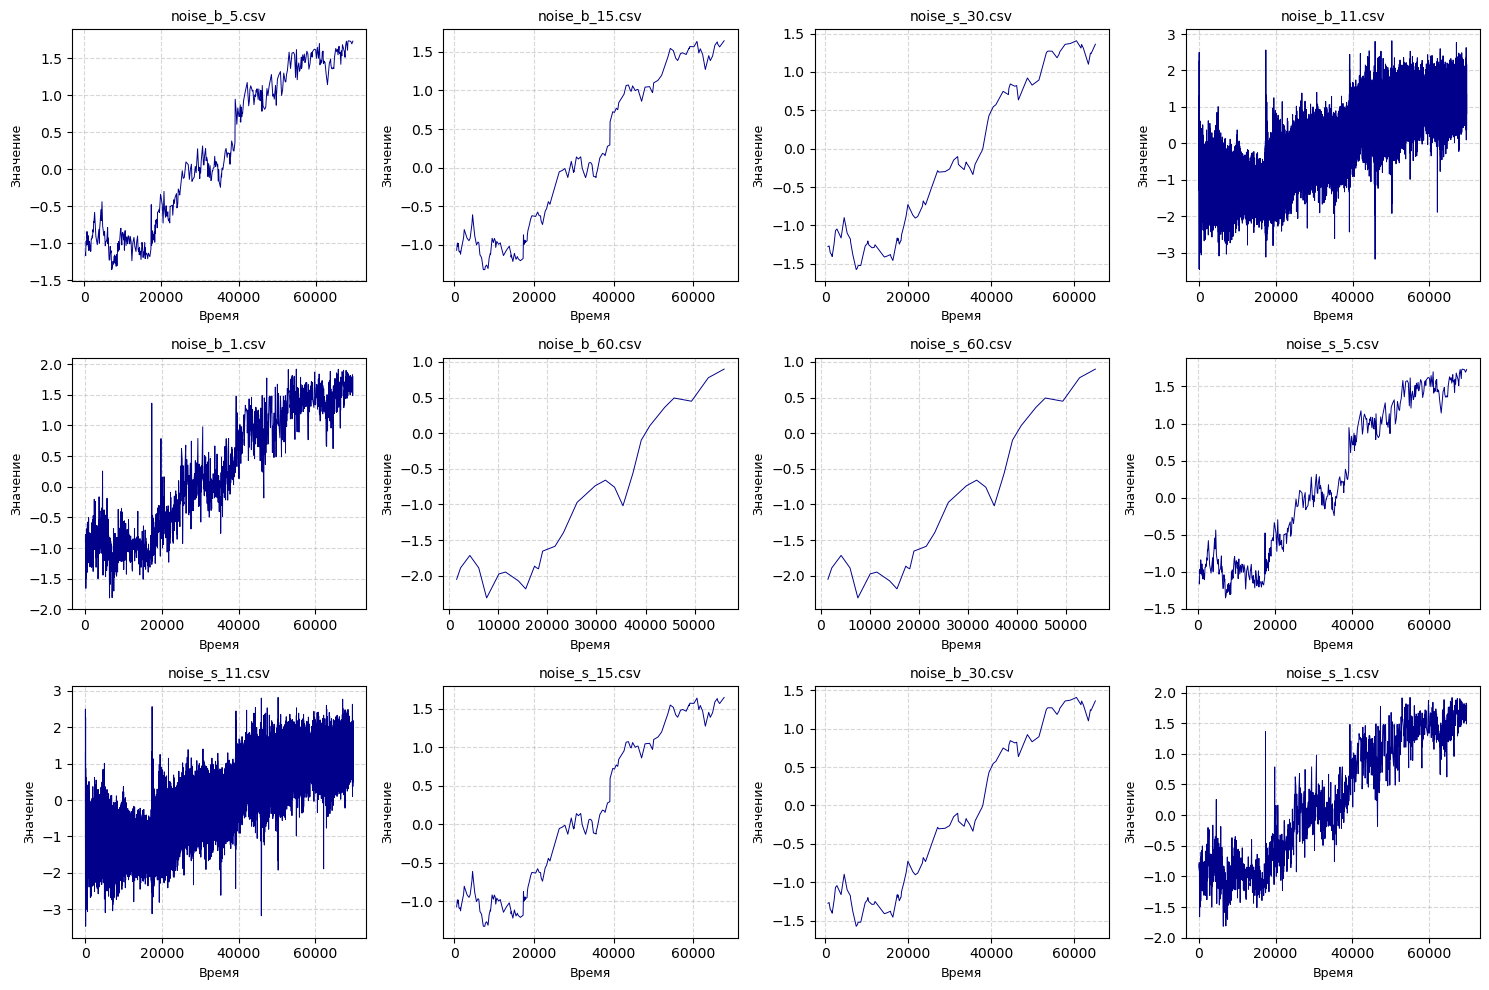

In [62]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/SBERP/noises"
plot_standardized_noise_grid(input_folder)

## GAZP

In [63]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_11.csv']

In [64]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0            2   70000040653           -0.345646
1            3   70000155147           -0.170383
2            4   70000155890           -0.500967
3            5   70000183362            0.069700
4            6   70000243791           -1.333909
...        ...           ...                 ...
197158  197214  183957329557            1.306912
197159  197215  183957464032            1.306912
197160  197216  183957637855            1.306912
197161  197217  183958224293            1.687357
197162  197218  183958392519            1.032422

[197163 rows x 3 columns]

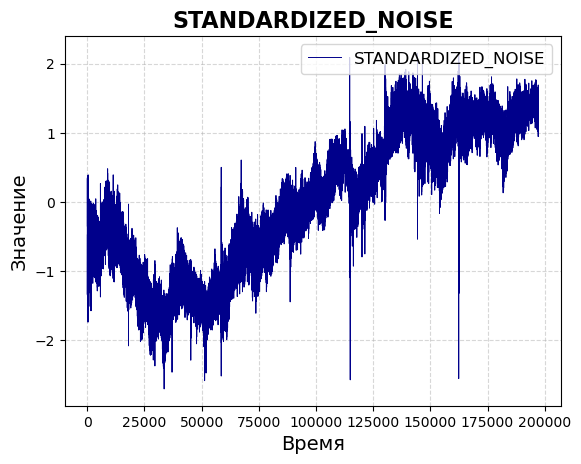

In [65]:
plot_standardized_noise(df)

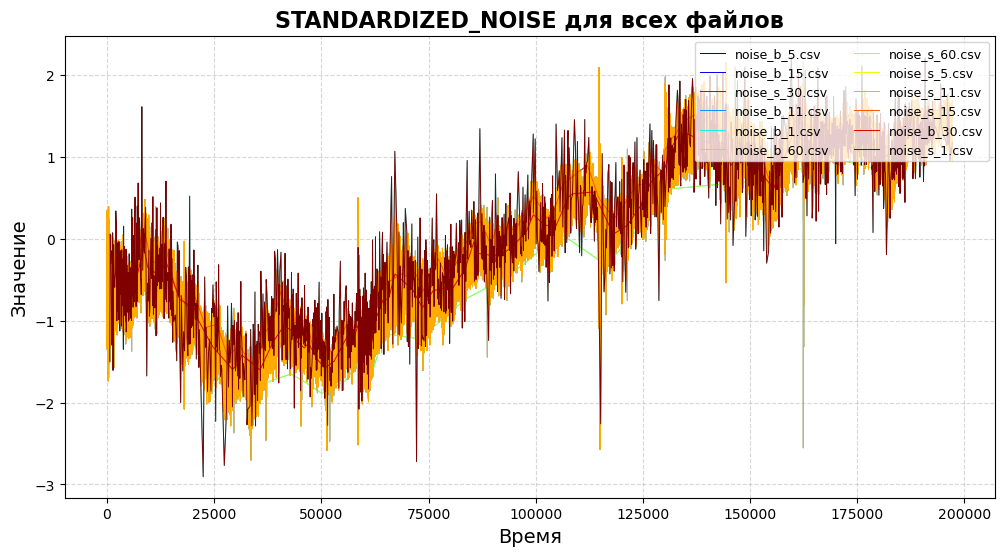

In [66]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises"
plot_standardized_noise_from_folder(input_folder)

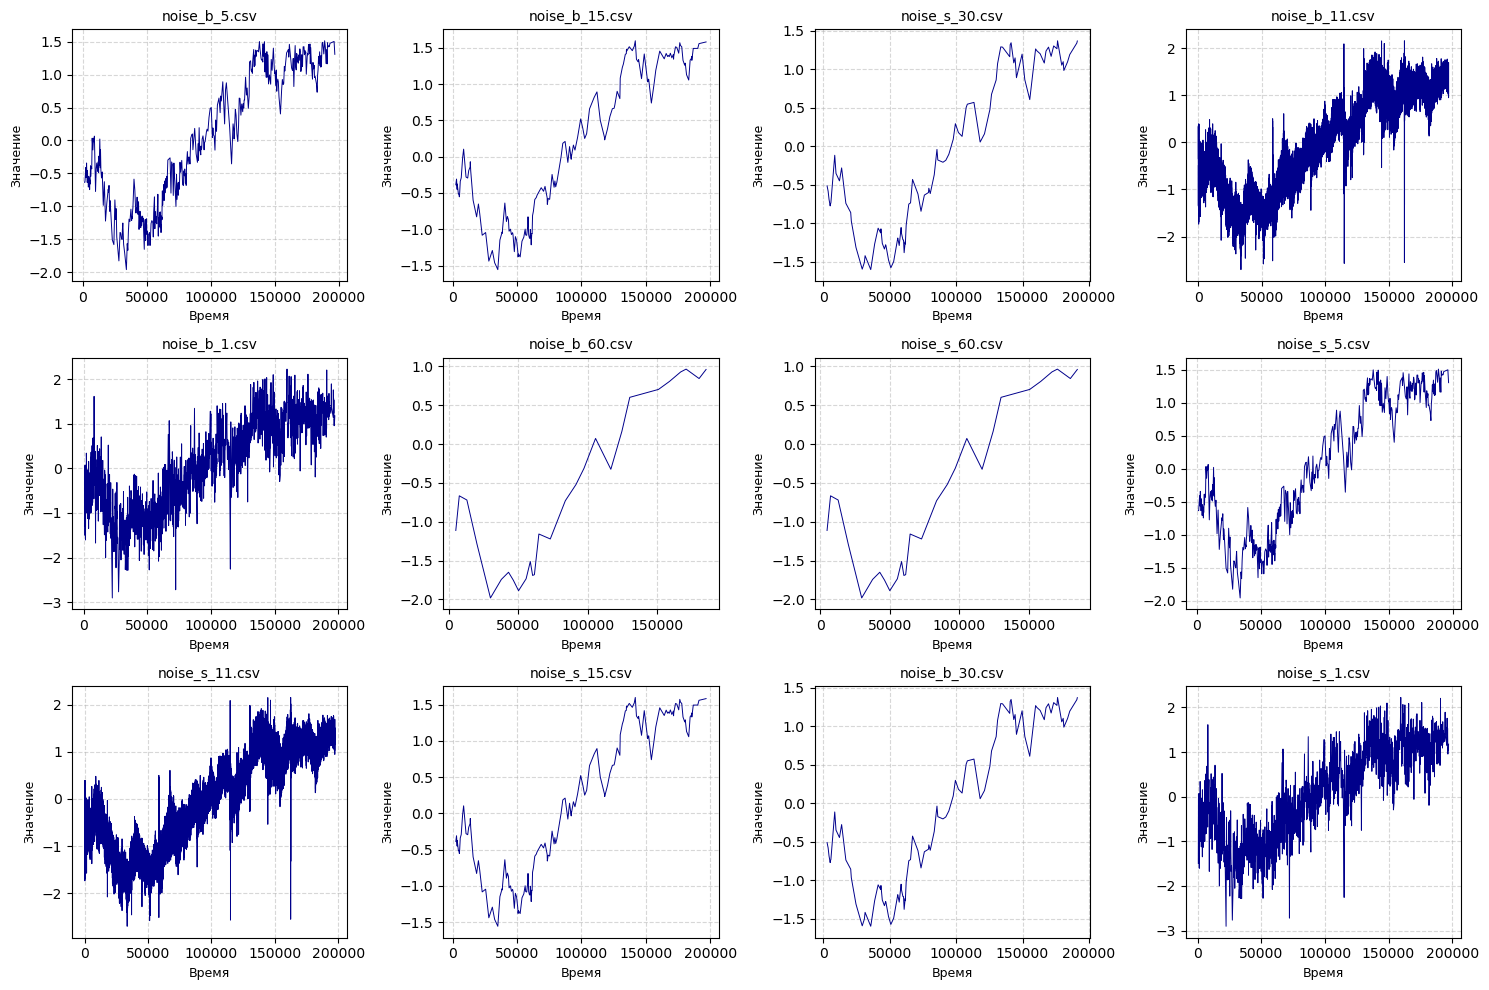

In [67]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/GAZP/noises"
plot_standardized_noise_grid(input_folder)

## LKOH

In [68]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_11.csv']

In [69]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0          2   70001306159            1.163173
1          3   70001325618            1.560851
2          4   70001330899            1.540284
3          5   70001389809            1.557107
4          6   70001416428            1.557107
...      ...           ...                 ...
58976  60298  183933290011            0.061929
58977  60299  183937439738            0.090908
58978  60300  183940087501            0.190002
58979  60301  183945004238            0.064751
58980  60302  183954021690            0.127376

[58981 rows x 3 columns]

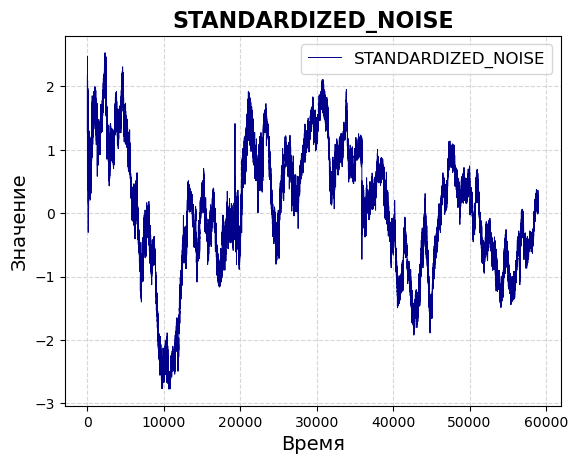

In [70]:
plot_standardized_noise(df)

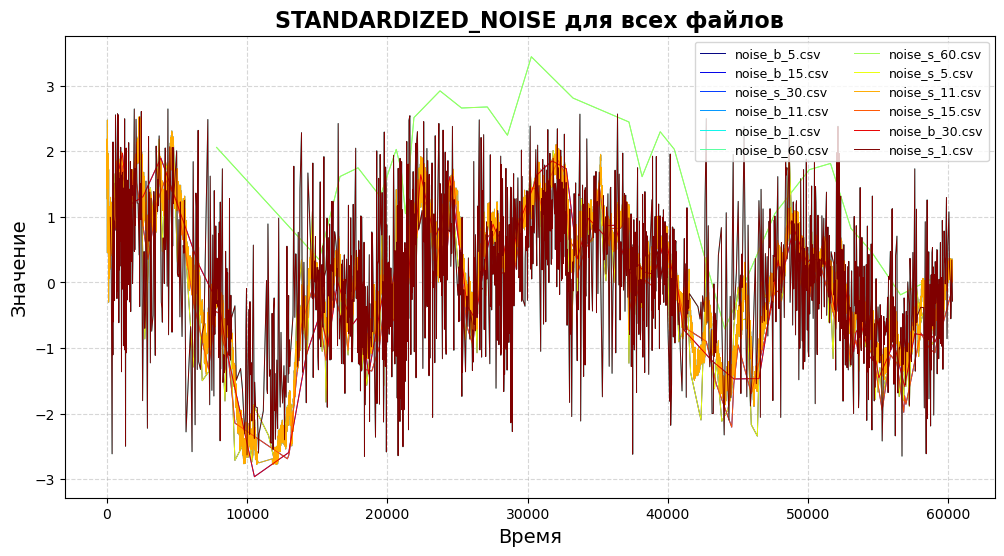

In [71]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises"
plot_standardized_noise_from_folder(input_folder)

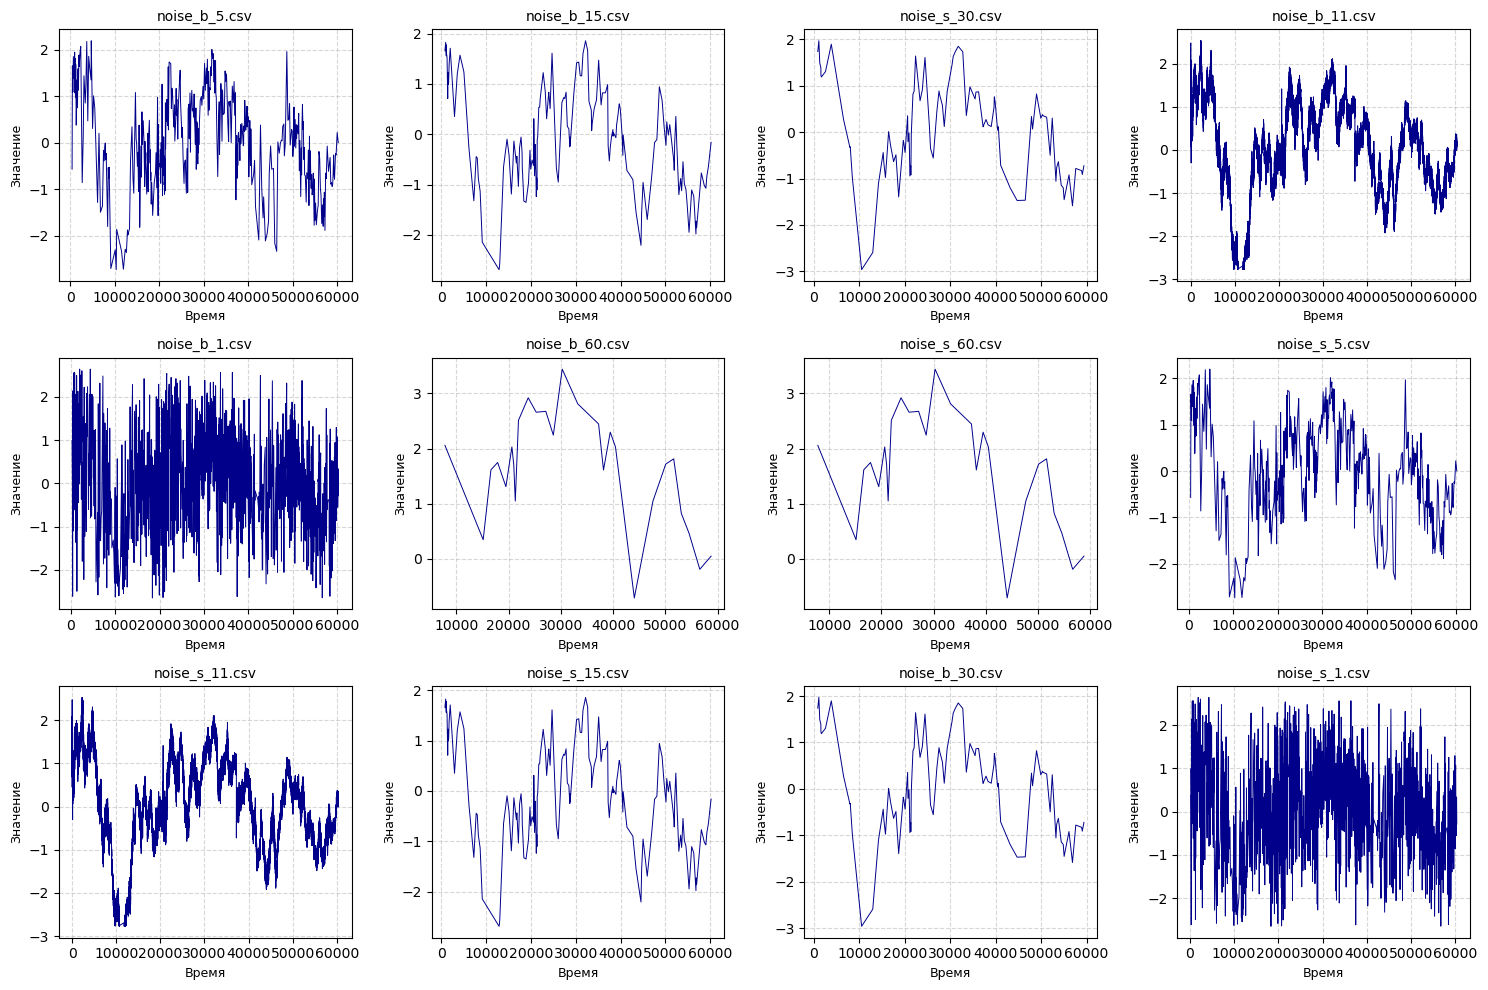

In [72]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/LKOH/noises"
plot_standardized_noise_grid(input_folder)

## NVTK

In [73]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_11.csv']

In [74]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0          2   70001333328           -0.096110
1          3   70001453920           -0.096110
2          4   70001471905           -1.514013
3          5   70001605833           -0.635264
4          6   70001647887            1.353188
...      ...           ...                 ...
32877  32892  183933103683            1.403391
32878  32893  183938399988            1.631392
32879  32894  183945203341            1.559094
32880  32895  183947078581            1.642501
32881  32896  183947078786            1.570203

[32882 rows x 3 columns]

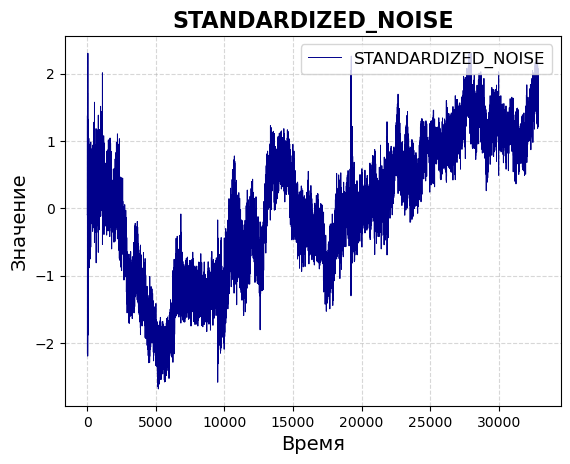

In [75]:
plot_standardized_noise(df)

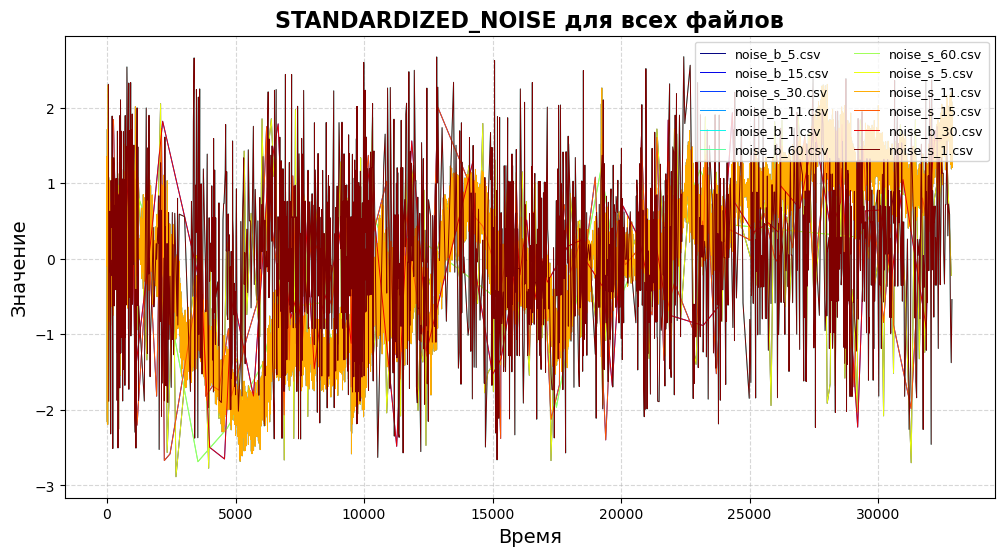

In [76]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises"
plot_standardized_noise_from_folder(input_folder)

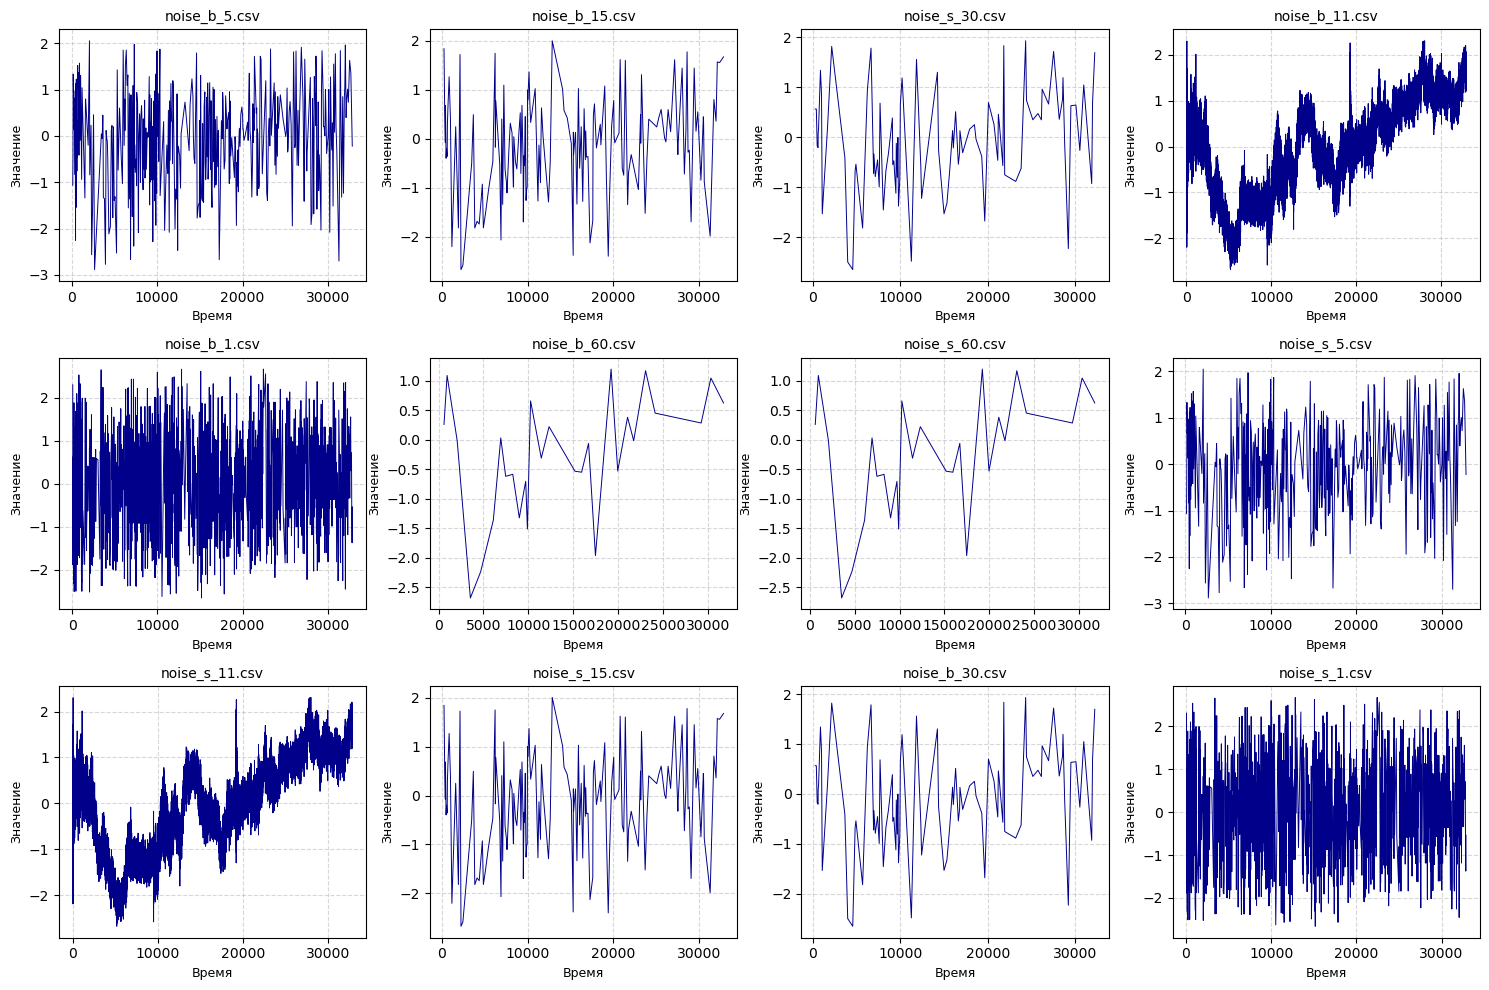

In [77]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/NVTK/noises"
plot_standardized_noise_grid(input_folder)

## ROSN

In [78]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_11.csv']

In [79]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0          2   70000147887           -0.571211
1          3   70000148947           -0.118599
2          4   70000154546           -0.544127
3          5   70000191276           -0.417180
4          6   70000229376           -0.062977
...      ...           ...                 ...
74736  82509  183929962462            1.951395
74737  82519  183937767333            1.992771
74738  82525  183941880228            2.003556
74739  82526  183944060940            1.964415
74740  82528  183947432372            1.977164

[74741 rows x 3 columns]

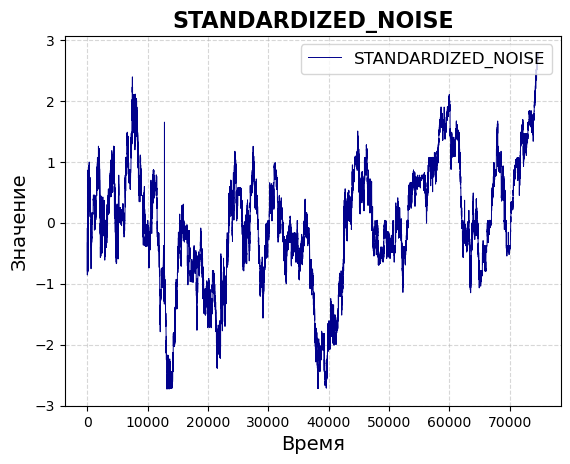

In [80]:
plot_standardized_noise(df)

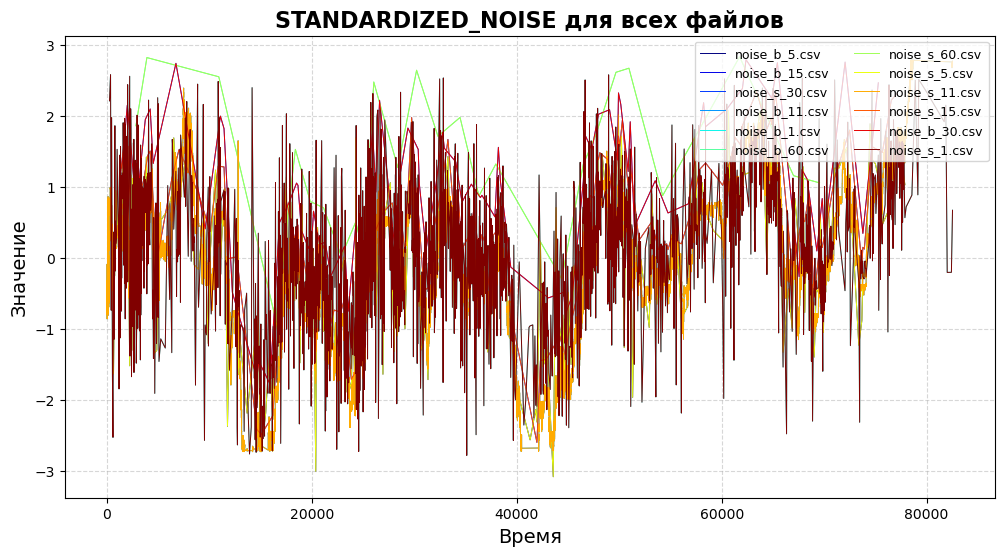

In [81]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises"
plot_standardized_noise_from_folder(input_folder)

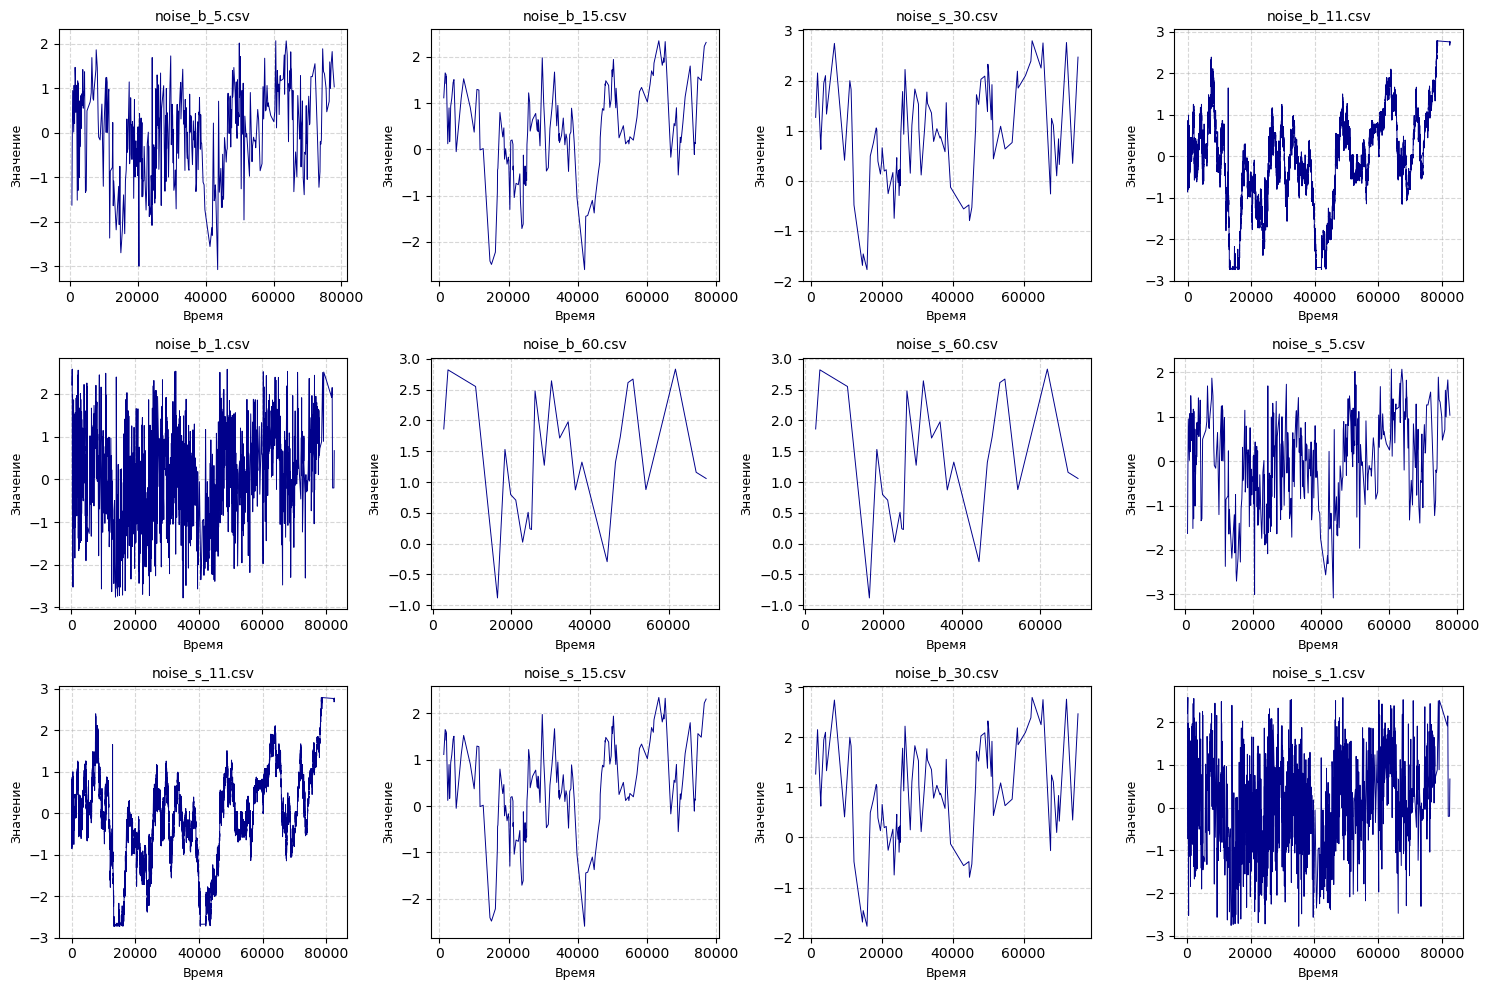

In [82]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/ROSN/noises"
plot_standardized_noise_grid(input_folder)

## TCSG

In [83]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_s_11.csv']

In [84]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises/noise_b_1.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0       150   70254648438            0.430582
1       187   70350779469           -0.100229
2       227   70450700916           -0.901632
3       351   70653974376           -0.704416
4       393   70751679250            1.015467
...     ...           ...                 ...
1989  80868  183551850305            0.829902
1990  80905  183652365138            0.032271
1991  81031  183757949803            1.496952
1992  81086  183851625650            1.037560
1993  81166  183951740246            0.041229

[1994 rows x 3 columns]

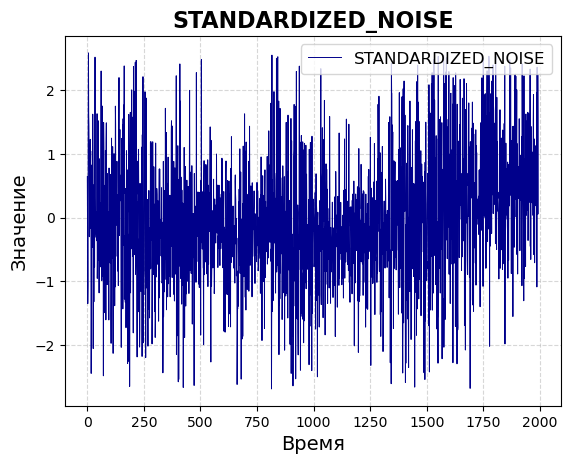

In [85]:
plot_standardized_noise(df)

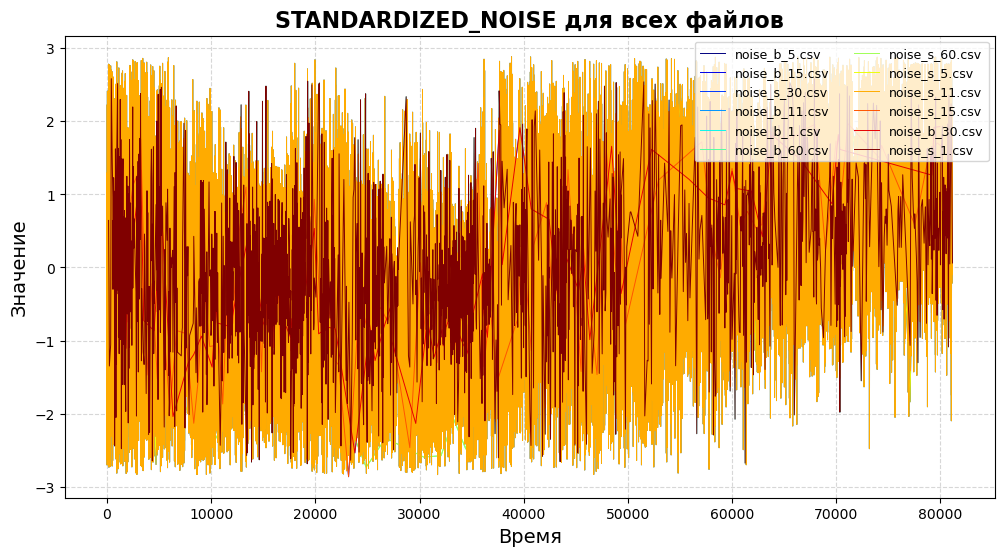

In [86]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises"
plot_standardized_noise_from_folder(input_folder)

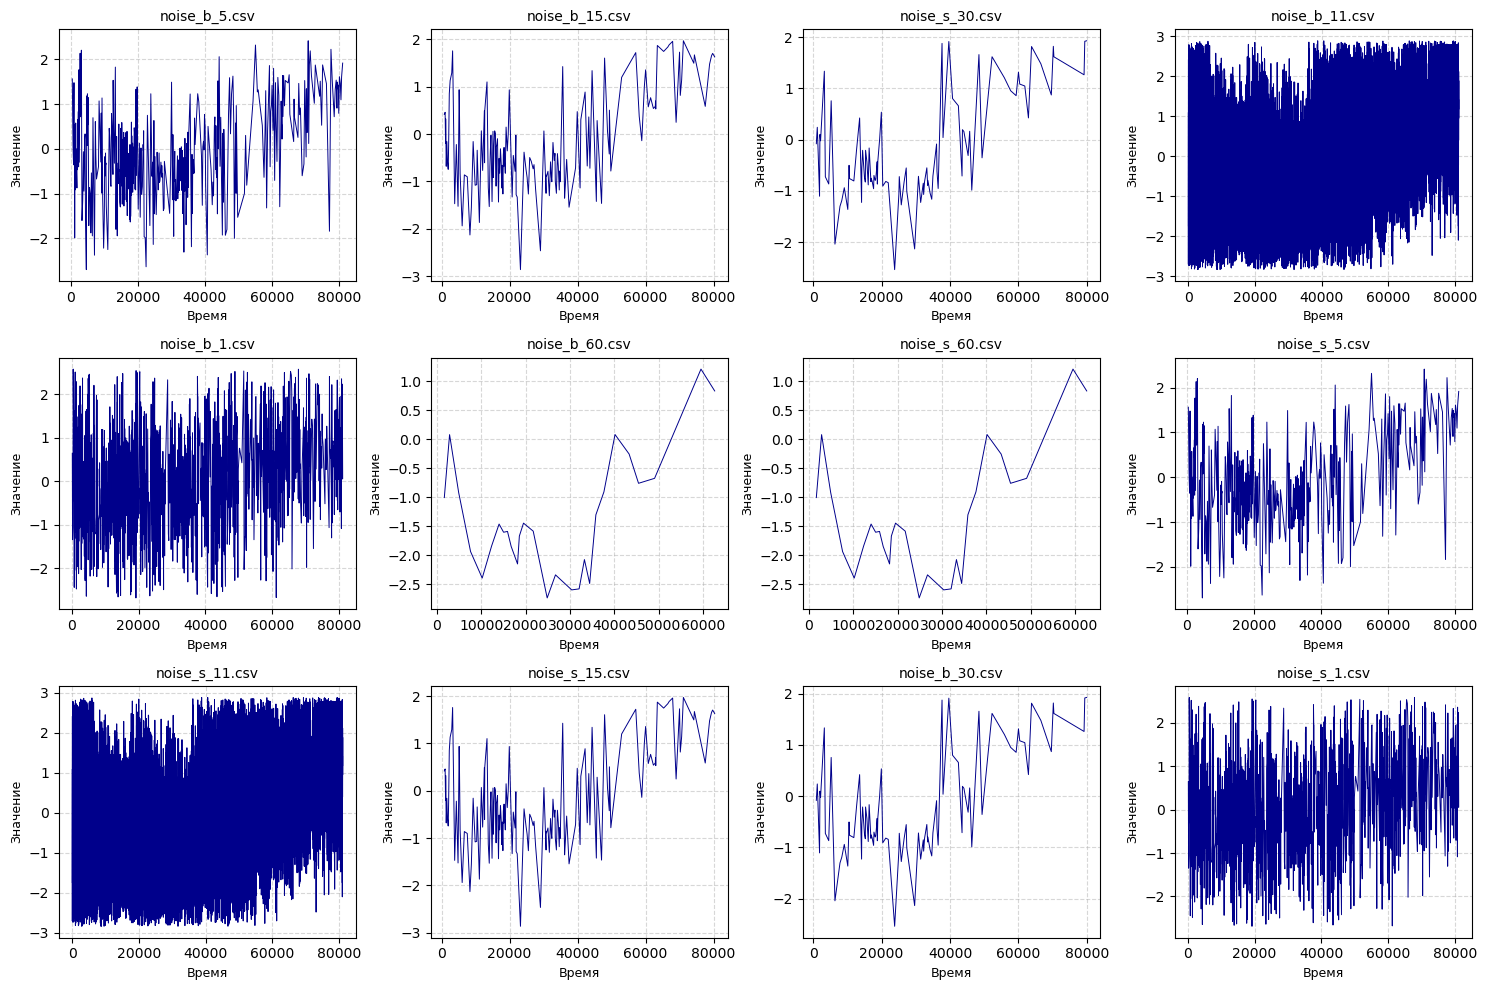

In [87]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TCSG/noises"
plot_standardized_noise_grid(input_folder)

## TRUR

In [88]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_11.csv']

In [89]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0              0  100001019447           -0.013444
1              1  100007358469           -0.013445
2              2  100007365428           -0.013445
3              3  100007587883           -0.013445
4              4  100008045493           -0.013445
...          ...           ...                 ...
1760141  1760261  184458336841            0.054856
1760142  1760262  184458709133            0.054856
1760143  1760263  184458732439            0.054856
1760144  1760264  184458825401            0.054856
1760145  1760265  184458872355            0.054856

[1760146 rows x 3 columns]

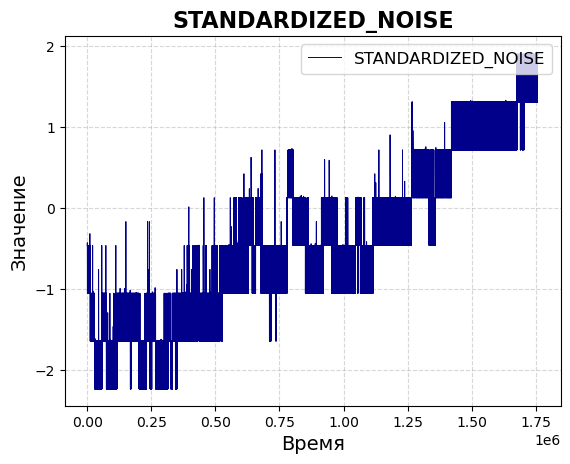

In [90]:
plot_standardized_noise(df)

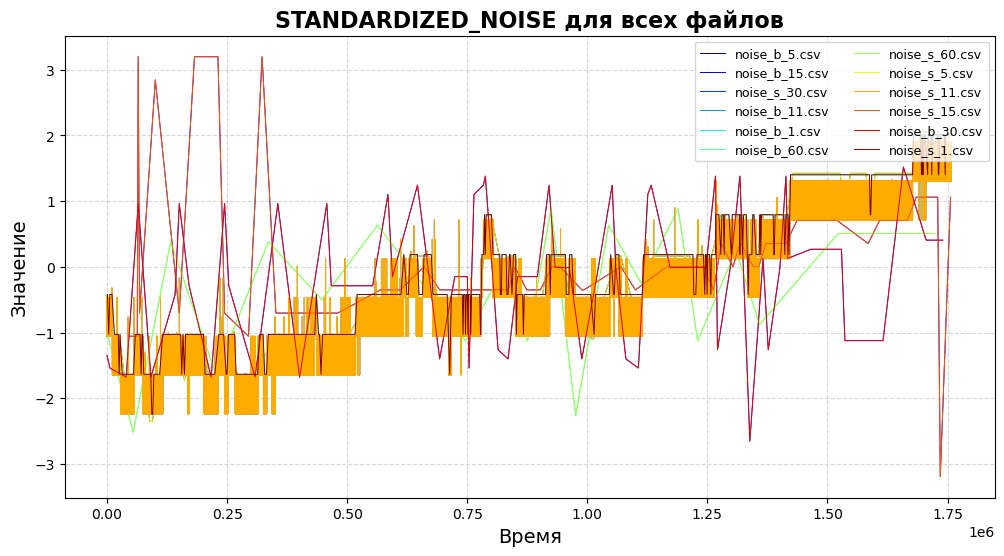

In [91]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises"
plot_standardized_noise_from_folder(input_folder)

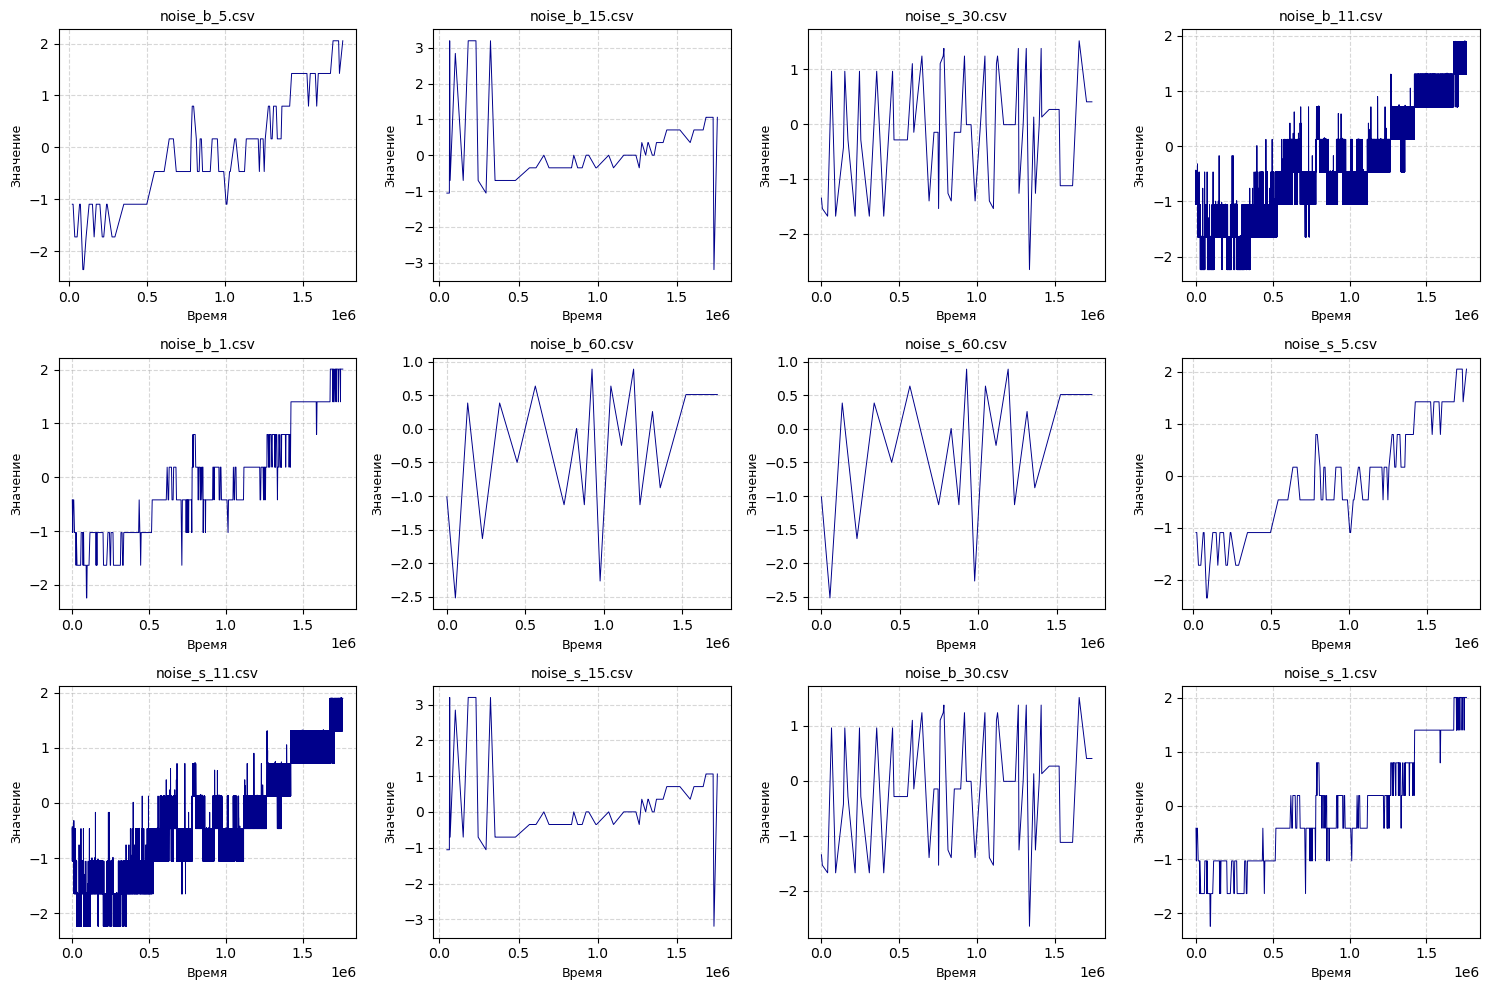

In [92]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/TRUR/noises"
plot_standardized_noise_grid(input_folder)

## !!!VTBR

In [93]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_11.csv']

In [94]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises/noise_s_60.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0    2647   85002317575           -0.169114
1    4003   95002709182           -0.169078
2    7195  105001359196           -0.169092
3   11019  115001178000           -0.169122
4   15012  125000519782           -0.169176
5   18210  135003192311           -0.169170
6   21119  145005457550           -0.169171
7   23934  155000132019           -0.169133
8   26342  165001056791           -0.169149
9   28750  175006649827           -0.169152
10  30687   70001341913           -0.169108
11  31678   75000405097           -0.169115
12  32305   85002727364           -0.169127
13  33825   95007219518           -0.169078
14  38940  105000160940           -0.169043
15  42293  115001409889           -0.169031
16  45526  125000316202           -0.168990
17  49360  135000121459           -0.169005
18  51594  145000043387           -0.169012
19  53726  155008113505           -0.169009
20  56132  165000063026           -0.169142
21  59711  175000187521           -0.169067
22  62065   70000031853           -0.168940
23  64770   75002189172           -0.168908
24  74451  105000636324           -0.168905
25  87718  145000659997           -0.168917
26  91218  155000099680           -0.168936
27  95357  165004059056           -0.168973
28  98777  175005434052           -0.168933

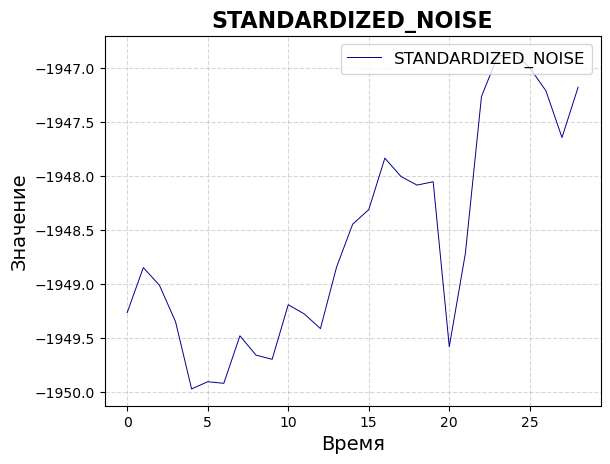

In [95]:
plot_standardized_noise(df)

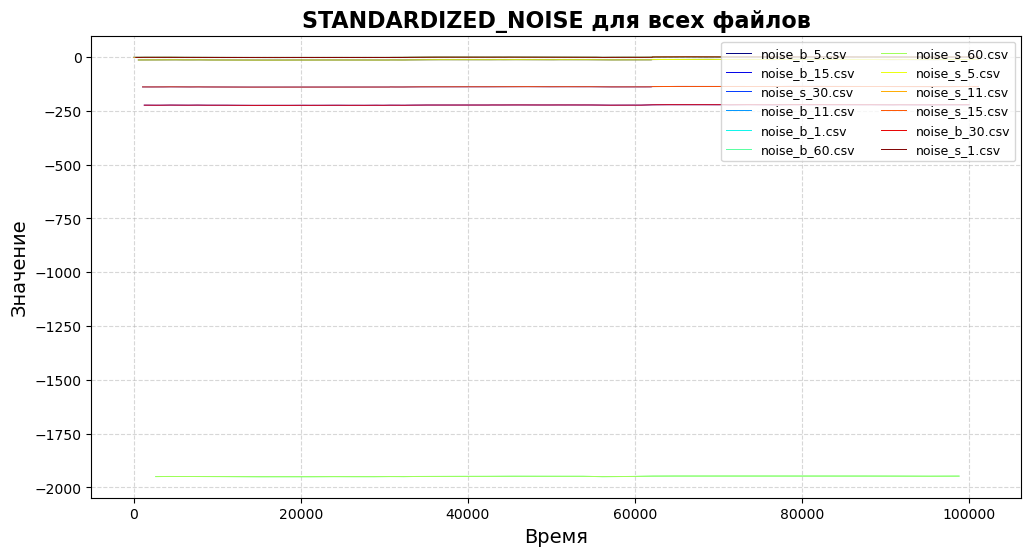

In [96]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises"
plot_standardized_noise_from_folder(input_folder)

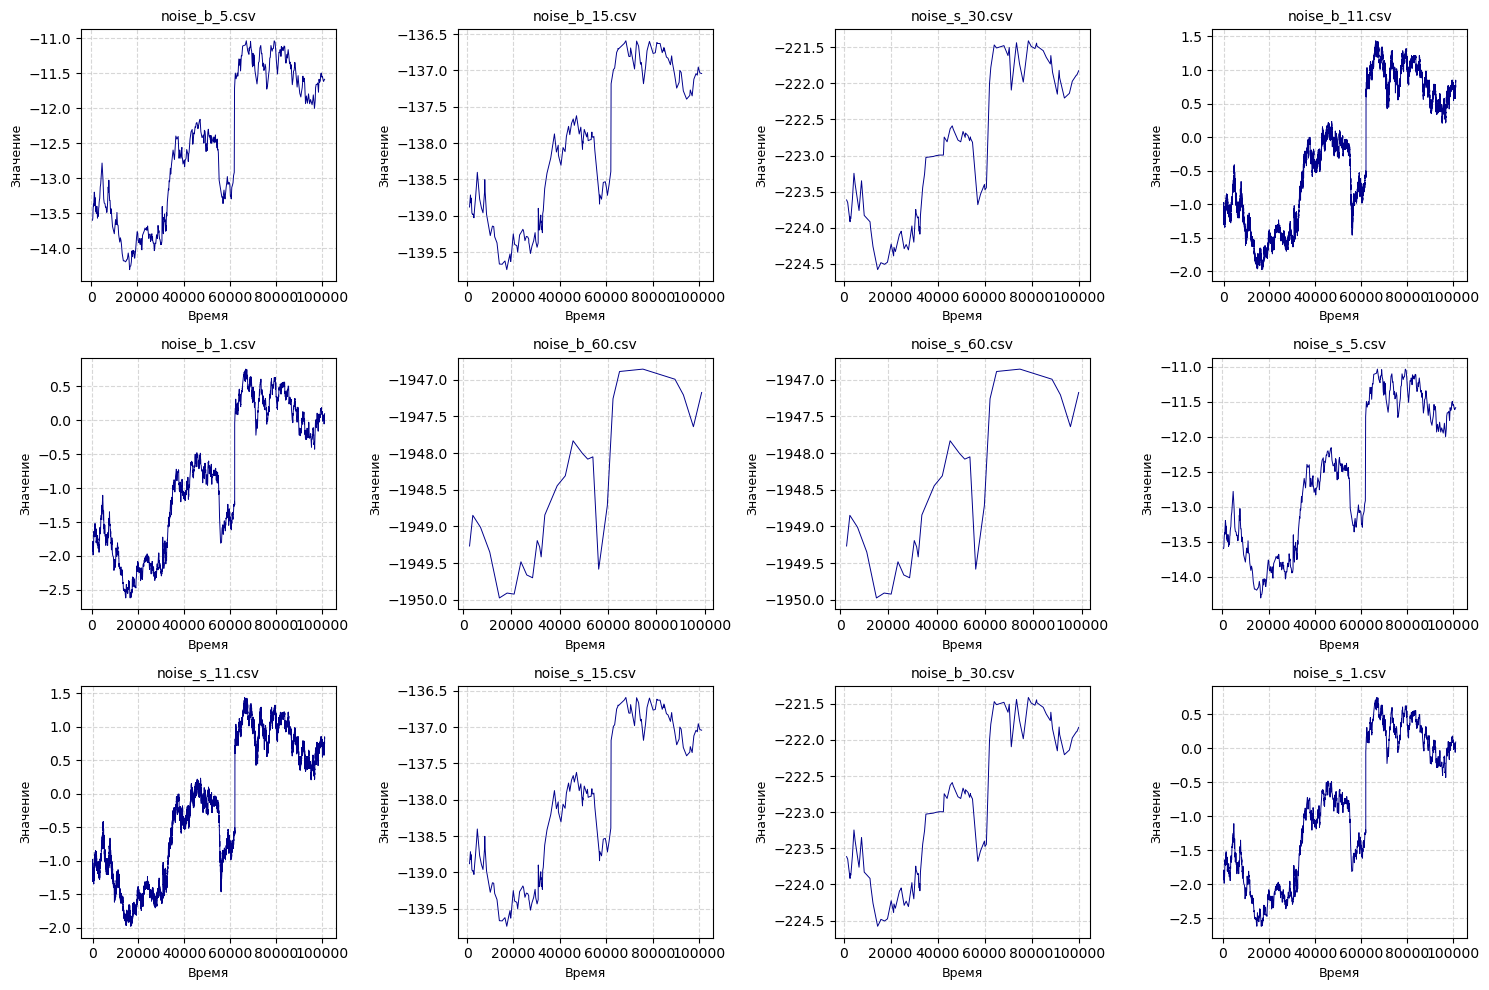

In [97]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/VTBR/noises"
plot_standardized_noise_grid(input_folder)

## YNDX

In [98]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX"
output_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises"

noise_files = process_files_with_standardization(input_folder, output_folder)

noise_files

['/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_b_11.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_b_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_b_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_b_5.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_60.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_b_1.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_15.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_b_30.csv',
 '/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_11.csv']

In [99]:
df_noise = pd.read_csv('/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises/noise_s_11.csv')
df = df_noise
df

index          TIME  STANDARDIZED_NOISE
0          2   70000514039           -0.402135
1          3   70001321119           -0.751672
2          4   70001324913           -1.231474
3          5   70001325306           -0.765426
4          6   70001329993           -0.285623
...      ...           ...                 ...
89612  89675  183947388130            1.444179
89613  89676  183949627702            0.472618
89614  89677  183952649213            1.583993
89615  89678  183953775581            0.376657
89616  89679  183953933728            0.927511

[89617 rows x 3 columns]

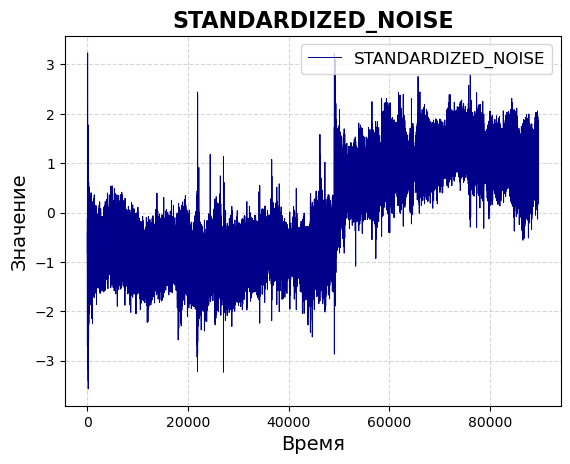

In [100]:
plot_standardized_noise(df)

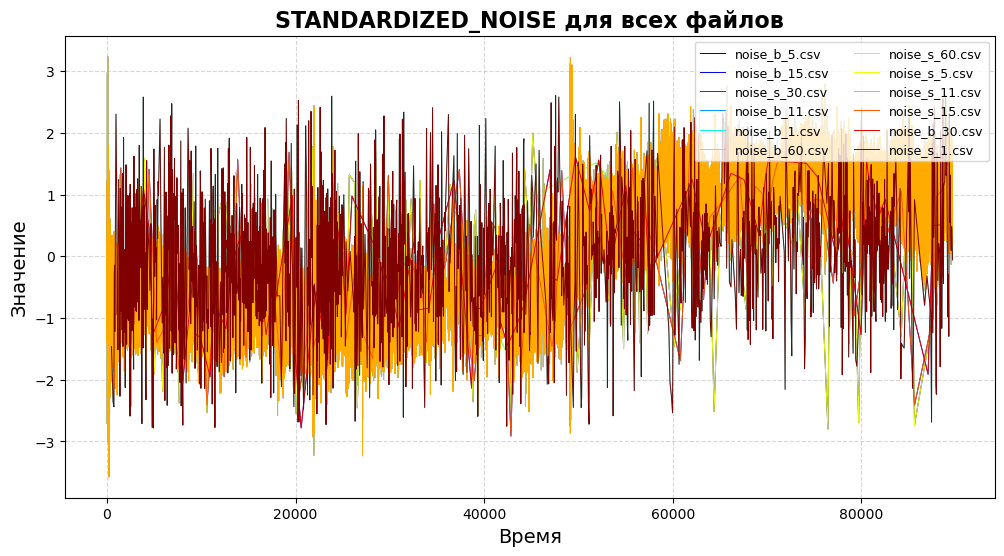

In [101]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises"
plot_standardized_noise_from_folder(input_folder)

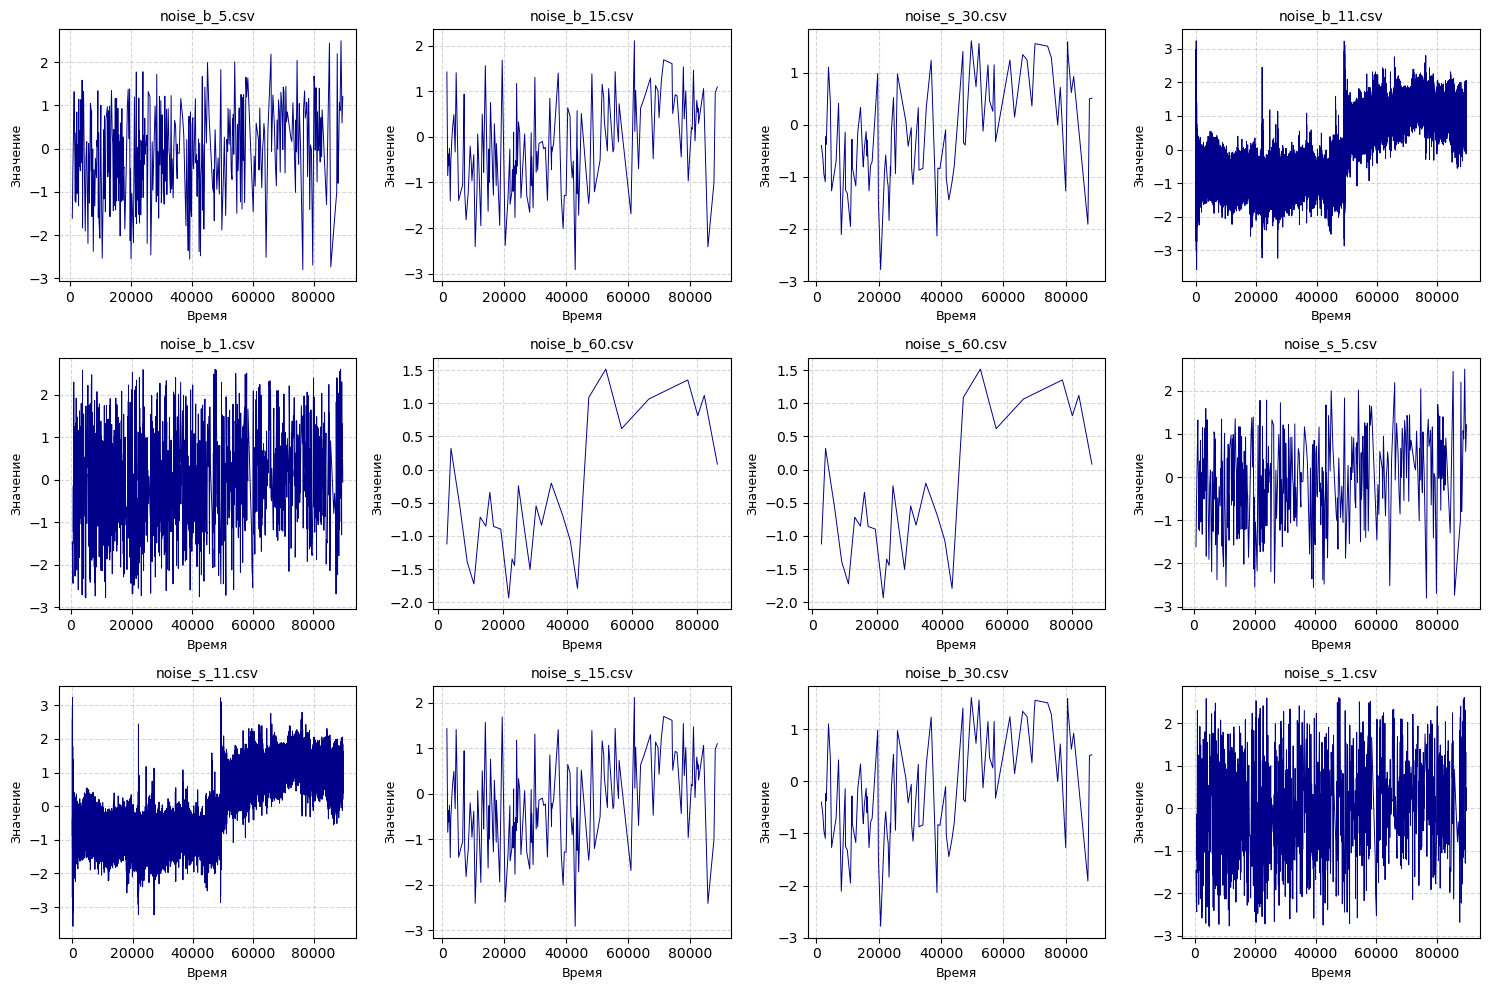

In [102]:
input_folder = "/Users/mariapavleeva/Diplom_FTiAD/moex_data/YNDX/noises"
plot_standardized_noise_grid(input_folder)